In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Đường dẫn tới thư mục chứa các file txt ===
folder = "baseline_results"

data = []

for filename in os.listdir(folder):
    if not filename.endswith(".txt"):
        continue

    filepath = os.path.join(folder, filename)

    # Tách tên file theo template model_technique_task
    parts = filename.replace(".txt", "").split("_")
    if len(parts) >= 3:
        model = parts[0]
        task = "_".join(parts[-2:])
        technique = "_".join(parts[1:-2])
    else:
        continue

    with open(filepath, "r", encoding="utf-8") as f:
        content = f.read()

    # --- Phân loại loại kết quả ---
    if "accuracy" in content or "precision" in content:  # classification_report
        # Tìm accuracy trong phần báo cáo
        match = re.search(r"accuracy\s+([\d\.]+)", content)
        match_line = re.search(r"(macro avg)\s+([\d\.]+)\s+([\d\.]+)\s+([\d\.]+)", content)
        if match_line:
            precision, recall, f1 = map(float, match_line.groups()[1:])
        else:
            precision = recall = f1 = None
        accuracy = float(match.group(1)) if match else None
        data.extend([
            {"model": model, "technique": technique, "task": task, "metric": "accuracy", "value": accuracy},
            # {"model": model, "technique": technique, "task": task, "metric": "precision", "value": precision},
            # {"model": model, "technique": technique, "task": task, "metric": "recall", "value": recall},
            # {"model": model, "technique": technique, "task": task, "metric": "f1-score", "value": f1},
        ])

    elif "MAE" in content:  # regression result
        match = re.search(r"MAE[:\s]+([\d\.]+)", content)
        mae = float(match.group(1)) if match else None
        data.append({
            "model": model,
            "technique": technique,
            "task": task,
            "metric": "MAE",
            "value": mae
        })

# === Tạo DataFrame tổng hợp ===
df = pd.DataFrame(data)

# === Lưu lại nếu cần ===
df.to_csv("PM100-charts_pdf/summary_results.csv", index=False)
df.to_excel("PM100-charts_pdf/summary_results.xlsx", index=False)
df

,model,technique,task,metric,value
0,CatBoost,hpcb-multitask_anon_template1,cpu_pcon,MAE,343.7501
1,CatBoost,hpcb-multitask_anon_template1,job_state,accuracy,0.8000
2,CatBoost,hpcb-multitask_anon_template1,mem_pcon,MAE,109.1557
3,CatBoost,hpcb-multitask_anon_template1,node_pcon,MAE,2007.7768
4,CatBoost,hpcb-multitask_anon_template1,run_time,MAE,221.2374
...,...,...,...,...,...
170,XGB,sb_anon_template5,node_pcon,MAE,2102.5501
171,XGB,sb_anon_template5,run_time,MAE,216.6696
172,XGB,sb_anon_template_full,job_state,accuracy,0.8100
173,XGB,sb_anon_template_full,node_pcon,MAE,1908.8749


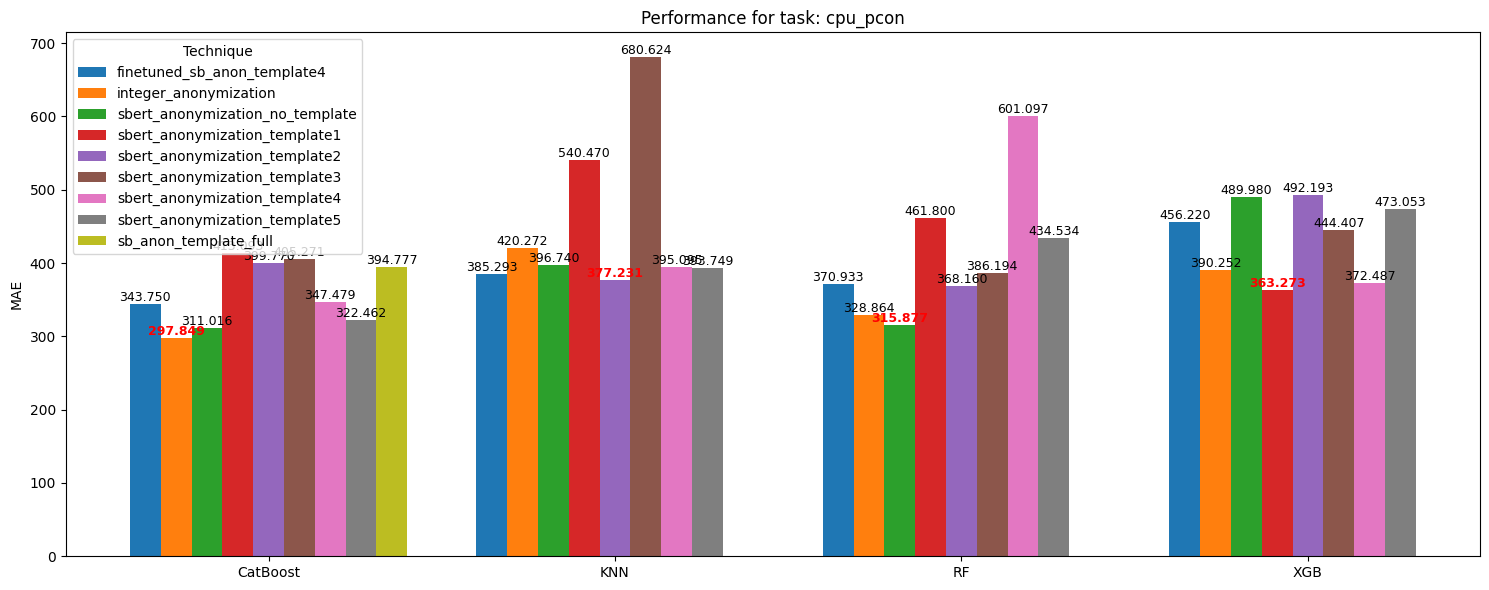

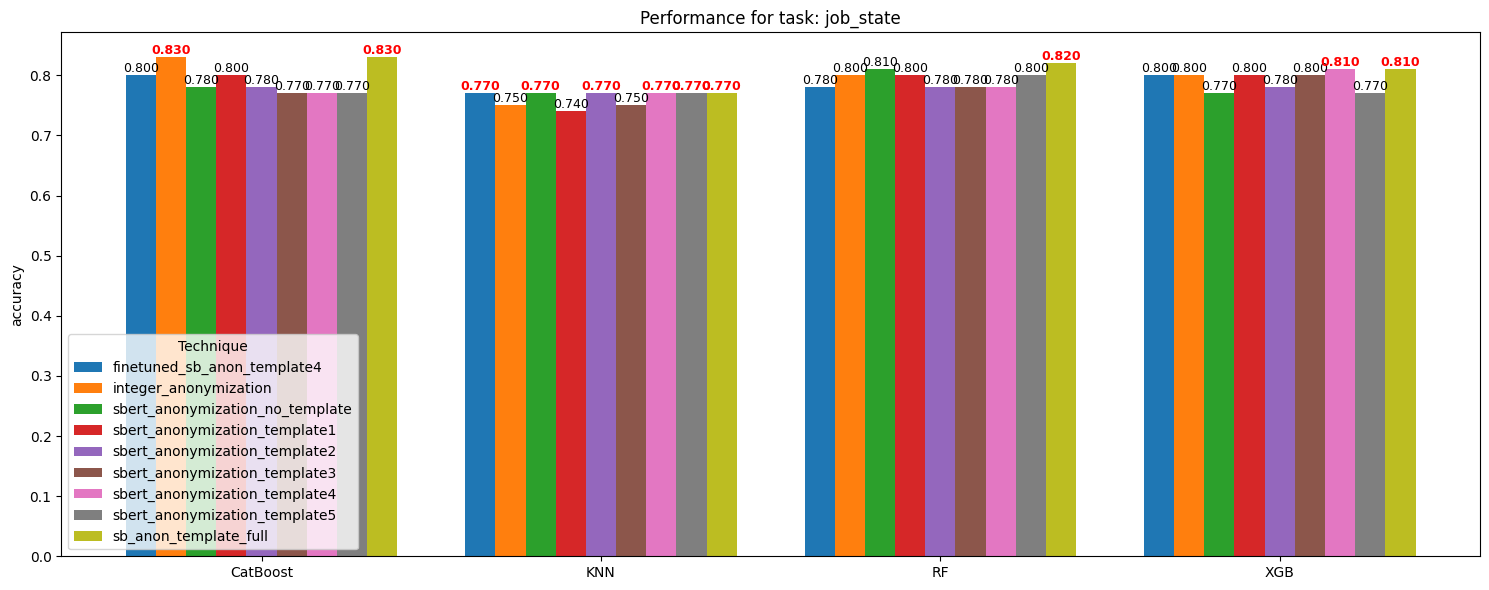

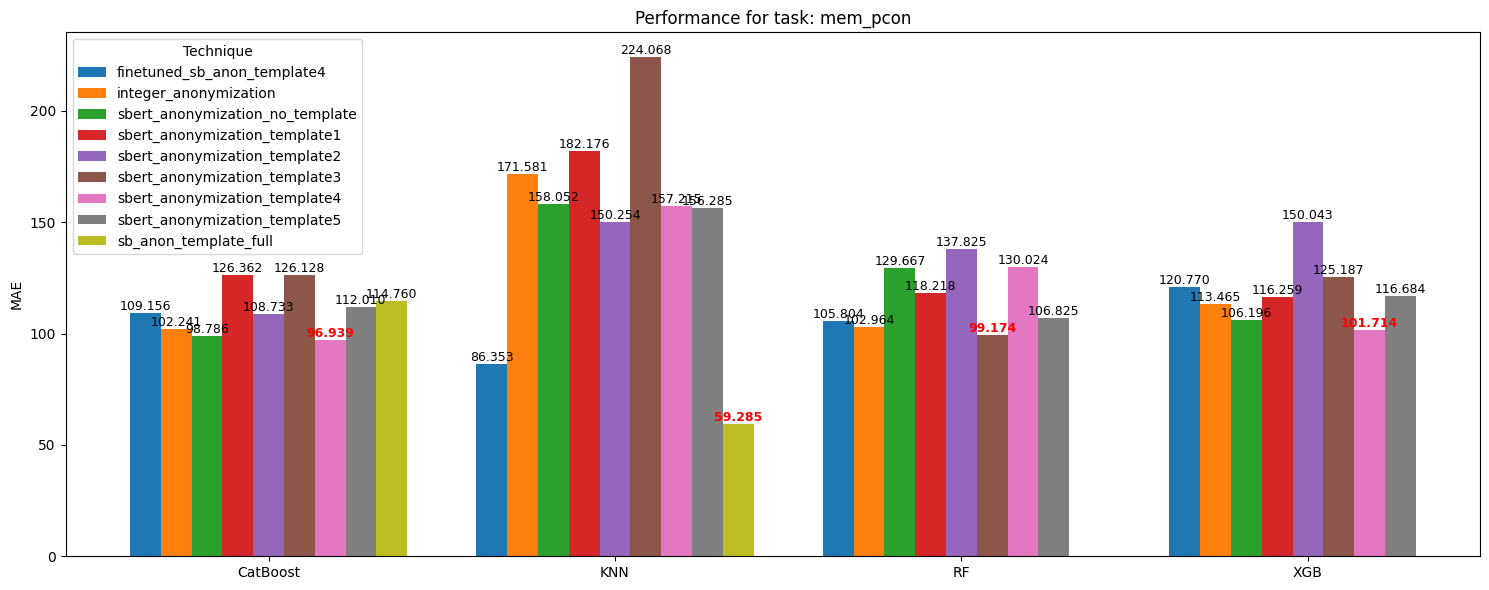

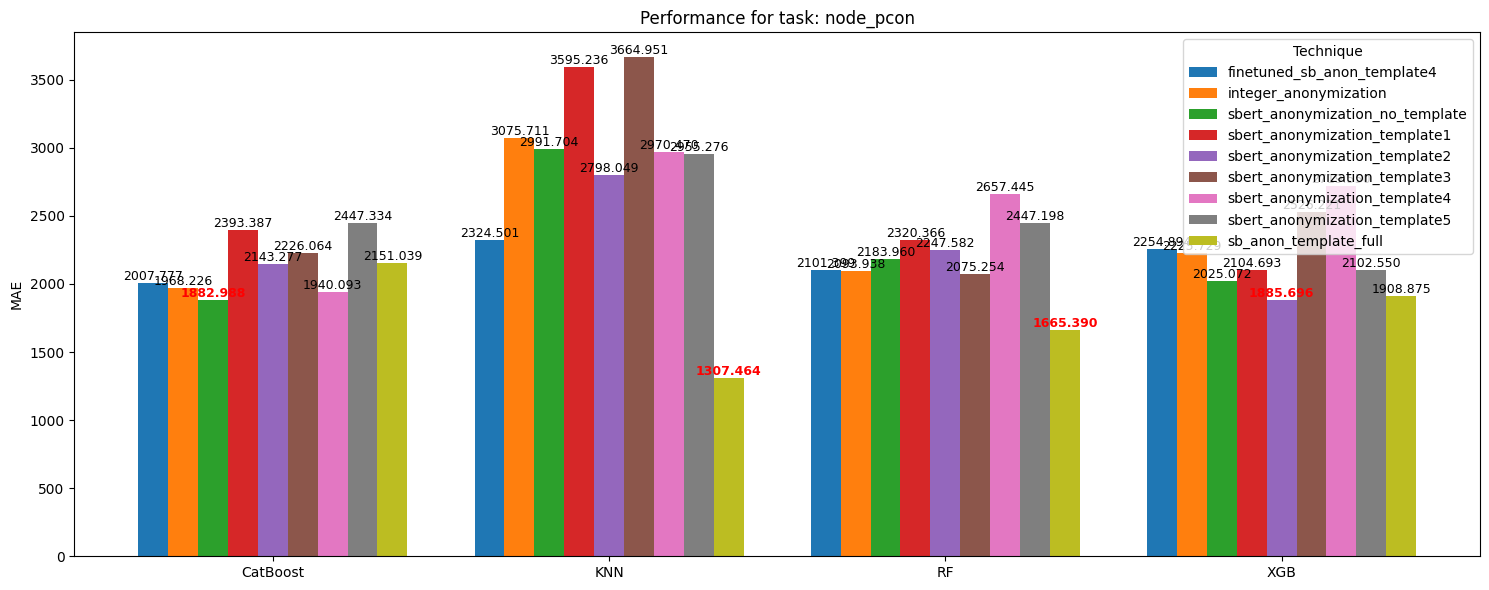

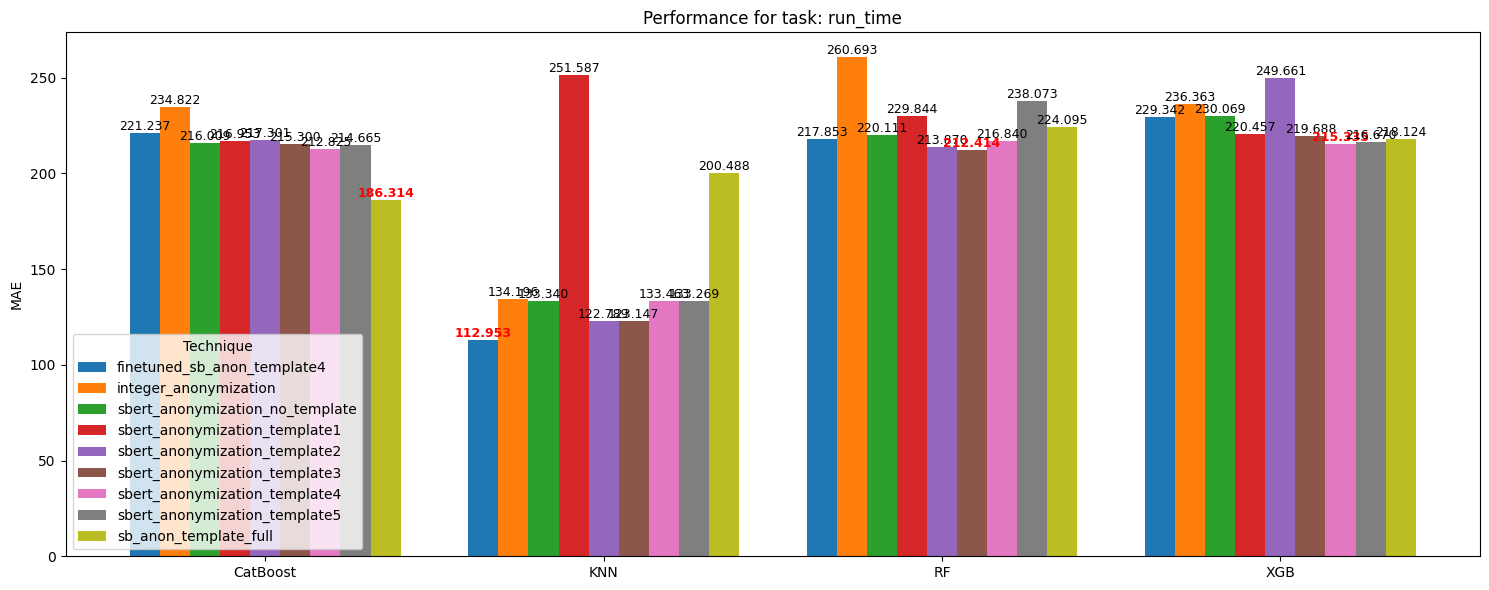

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Các metric cần MIN thay vì MAX
minimize_metrics = {"mae", "rmse", "mse", "loss", "error"}
tech_label_map = {
    "int_anon": "integer_anonymization",
    "sb": "sbert_raw_data",
    "sb_anon": "sbert_anonymization_no_template",
    "hpcb-multitask_anon_template1": "finetuned_sb_anon_template4",
    "sb_anon_template1": "sbert_anonymization_template1",
    "sb_anon_template2": "sbert_anonymization_template2",
    "sb_anon_template3": "sbert_anonymization_template3",
    "sb_anon_template4": "sbert_anonymization_template4",
    "sb_anon_template5": "sbert_anonymization_template5",
}

for task in df["task"].unique():
    subset = df[df["task"] == task].sort_values(["model", "technique"])

    models = subset["model"].unique()
    techniques = subset["technique"].unique()
    metric_name = subset["metric"].iloc[0].lower()

    x = np.arange(len(models))
    width = 0.8 / max(1, len(techniques))

    plt.figure(figsize=(15, 6))

    # Chọn hàm min/max tùy metric
    if any(m in metric_name for m in minimize_metrics):
        best_values = subset.groupby("model")["value"].min().to_dict()
        better = lambda val, best: np.isclose(val, best) or val <= best
    else:
        best_values = subset.groupby("model")["value"].max().to_dict()
        better = lambda val, best: np.isclose(val, best) or val >= best

    # Vẽ từng technique (align values to full models list to avoid shape mismatch)
    for i, tech in enumerate(techniques):
        sub_t = subset[subset["technique"] == tech]
        # build values aligned to 'models' order; use np.nan for missing model-tech combos
        values = np.array([sub_t[sub_t["model"] == m]["value"].values[0]
                           if len(sub_t[sub_t["model"] == m]) > 0 else np.nan
                           for m in models])
        positions = x + (i - len(techniques)/2) * width + width/2
        bars = plt.bar(positions, values, width, label=tech_label_map.get(tech, tech))

        # Gắn nhãn; skip missing (NaN) entries to keep lengths consistent
        for bar, val, model in zip(bars, values, models):
            if np.isnan(val):
                continue
            height = bar.get_height()
            if better(val, best_values.get(model, val)):
                plt.text(
                    bar.get_x() + bar.get_width()/2,
                    height,
                    f"{height:.3f}",
                    ha="center", va="bottom",
                    fontsize=9, color="red", fontweight="bold"
                )
            else:
                plt.text(
                    bar.get_x() + bar.get_width()/2,
                    height,
                    f"{height:.3f}",
                    ha="center", va="bottom", fontsize=9
                )

    plt.xticks(x, models, rotation=0)
    plt.title(f"Performance for task: {task}")
    plt.ylabel(subset["metric"].iloc[0])
    plt.legend(title="Technique")
    plt.tight_layout()
    plt.show()


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Font và style
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
rcParams['font.size'] = 10
rcParams['axes.linewidth'] = 1.2
rcParams['grid.alpha'] = 0.3

# Mapping tên kỹ thuật
tech_label_map = {
    "int_anon": "IntAnon",
    "sb": "SBERT Raw",
    "sb_anon": "SBERT NoTpl",
    "hpcb-multitask_anon_template1": "Finetuned SBERT Tpl4",
    "sb_anon_template1": "SBERT Tpl1",
    "sb_anon_template2": "SBERT Tpl2",
    "sb_anon_template3": "SBERT Tpl3",
    "sb_anon_template4": "SBERT Tpl4",
    "sb_anon_template5": "SBERT Tpl5",
    "sb_anon_template6": "SBERT Tpl6",
}

# Bảng màu chính
color_palette = [
    "#0B3C5D",  # 1. Deep Navy Blue
    "#1D65A6",  # 2. Medium Blue
    "#3F88C5",  # 3. Sky Blue
    "#8EC0E4",  # 4. Light Ice Blue
    "#1B9AAA",  # 5. Teal Blue
    "#15959F",  # 6. Cool Teal
    "#4F5D75",  # 7. Steel Gray-Blue
    "#5C5470",  # 8. Lavender Gray
    "#7A77B9",  # 9. Cold Purple
    "#A7A5C6",  # 10. Soft Cool Lilac
]



def plot_single_task_chart(df, task_name, metric_name):
    """
    Vẽ chart cho một task và một metric cụ thể
    """
    subset = df[(df["task"] == task_name) & (df["metric"] == metric_name)].copy()
    if len(subset) == 0:
        print(f"❌ Không có dữ liệu cho task {task_name} + metric {metric_name}")
        return None

    subset = subset.sort_values(["model", "technique"])
    models = subset["model"].unique()
    techniques = subset["technique"].unique()
    metric_display = metric_name

    n_models = len(models)
    n_techniques = len(techniques)
    fig, ax = plt.subplots(figsize=(12, 7))

    # Bar geometry
    group_width = 0.8
    bar_width = group_width / n_techniques
    bar_spacing = bar_width * 0.1
    actual_bar_width = bar_width * 0.9
    x = np.arange(n_models)

    # Patterns & Colors
    pattern_palette = ['|||', '///', '+++', '\\\\\\', '---', '...', 'ooo', 'xxx', '***', 'OOO']
    patterns = {tech: pattern_palette[i % len(pattern_palette)] for i, tech in enumerate(techniques)}
    colors = {tech: color_palette[i % len(color_palette)] for i, tech in enumerate(techniques)}

    # Determine metric direction
    minimize_metrics = ['mae', 'mse', 'rmse', 'error', 'loss', 'duration', 'time']
    is_minimize_metric = any(m in metric_name.lower() for m in minimize_metrics)

    # Lấy giá trị tốt nhất của mỗi model (trên metric này)
    best_values = (
        subset.groupby("model")["value"].min().to_dict()
        if is_minimize_metric
        else subset.groupby("model")["value"].max().to_dict()
    )

    max_value = subset["value"].max()

    # Plot bars
    for i, tech in enumerate(techniques):
        sub_t = subset[subset["technique"] == tech]
        values = [sub_t[sub_t["model"] == m]["value"].values[0] if m in sub_t["model"].values else np.nan for m in models]

        group_start = x - group_width / 2
        bar_positions = group_start + i * (actual_bar_width + bar_spacing) + actual_bar_width / 2

        bars = ax.bar(
            bar_positions, values, actual_bar_width,
            label=tech_label_map.get(tech, tech),
            color=colors[tech], edgecolor='black', linewidth=1,
            hatch=patterns[tech], alpha=0.9
        )

        # Ghi label trên cột
        for bar, val, model in zip(bars, values, models):
            if np.isnan(val):
                continue
            height = bar.get_height()
            if val > 100 or 'duration' in metric_name.lower() or 'time' in metric_name.lower():
                label_text = f'{int(height)}'
            elif val < 1:
                label_text = f'{height:.3f}'
            else:
                label_text = f'{height:.2f}'

            # Check best value
            if is_minimize_metric:
                is_best = np.isclose(val, best_values.get(model), rtol=1e-5) or val <= best_values.get(model)
            else:
                is_best = np.isclose(val, best_values.get(model), rtol=1e-5) or val >= best_values.get(model)

            ax.text(
                bar.get_x() + bar.get_width() / 2, height,
                label_text, ha='center', va='bottom',
                fontsize=8,
                color='red' if is_best else 'black',
                fontweight='bold' if is_best else 'normal'
            )

    # Axis & labels
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric_display, fontsize=12, fontweight='bold')
    ax.set_title(f'Task: {task_name} | Metric: {metric_name}', fontsize=14, fontweight='bold', pad=20)

    direction_note = "Lower is better" if is_minimize_metric else "Higher is better"
    ax.text(0.02, 0.98, f"Note: {direction_note}",
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.3))

    ax.yaxis.grid(True, linestyle='--', alpha=0.4, linewidth=0.8)
    ax.set_axisbelow(True)
    ax.set_ylim(0, max_value * 1.15)

    ax.legend(
        title='Technique', fontsize=9, title_fontsize=10,
        loc='upper center', bbox_to_anchor=(0.5, -0.08),
        ncol=min(4, n_techniques), framealpha=0.95, edgecolor='gray'
    )

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    
    os.makedirs("PM100-charts_pdf", exist_ok=True)
    pdf_path = f"PM100-charts_pdf/{task_name}_{metric_name}.pdf"
    fig.savefig(pdf_path, format="pdf", dpi=300, bbox_inches="tight")

    print(f"✅ Đã lưu PDF: {pdf_path}")
    return fig

def plot_all_tasks(df):
    figures = {}
    for task in df["task"].unique():
        for metric in df[df["task"] == task]["metric"].unique():
            print(f"\n📊 Plotting chart for Task: {task}, Metric: {metric}")
            fig = plot_single_task_chart(df, task, metric)
            if fig is not None:
                figures[f"{task}_{metric}"] = fig
    return figures



📊 Plotting chart for Task: cpu_pcon, Metric: MAE


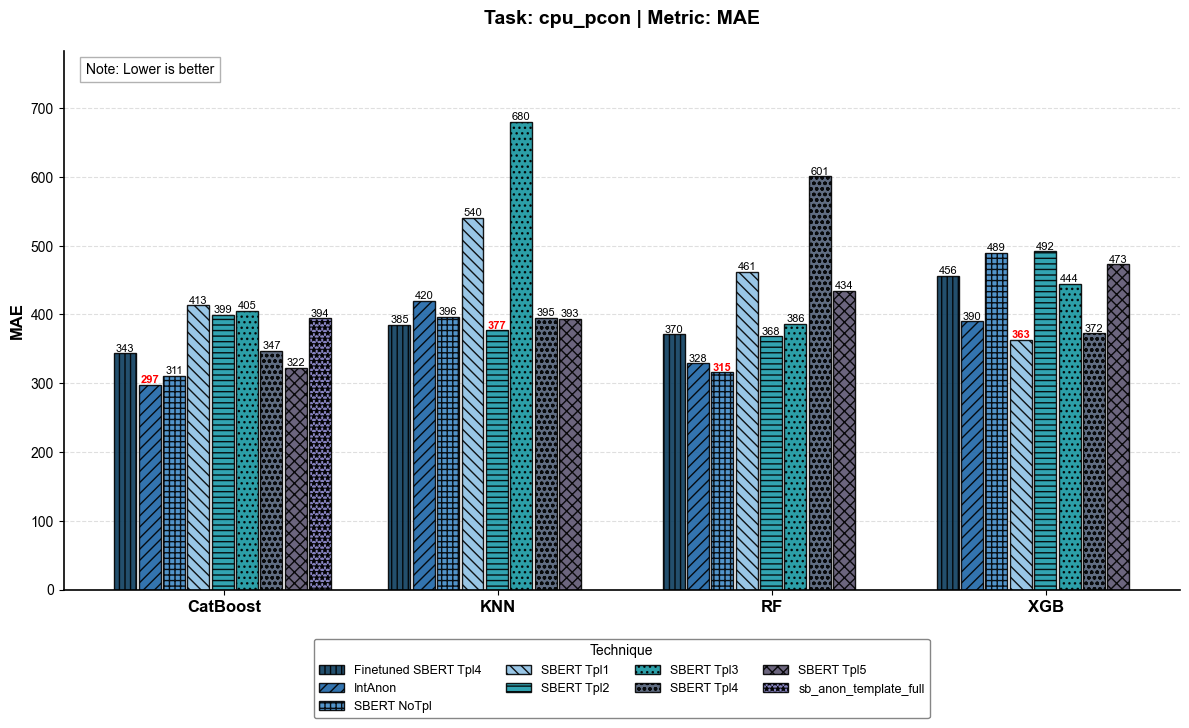

✅ Đã lưu PDF: PM100-charts_pdf/cpu_pcon_MAE.pdf

📊 Plotting chart for Task: job_state, Metric: accuracy


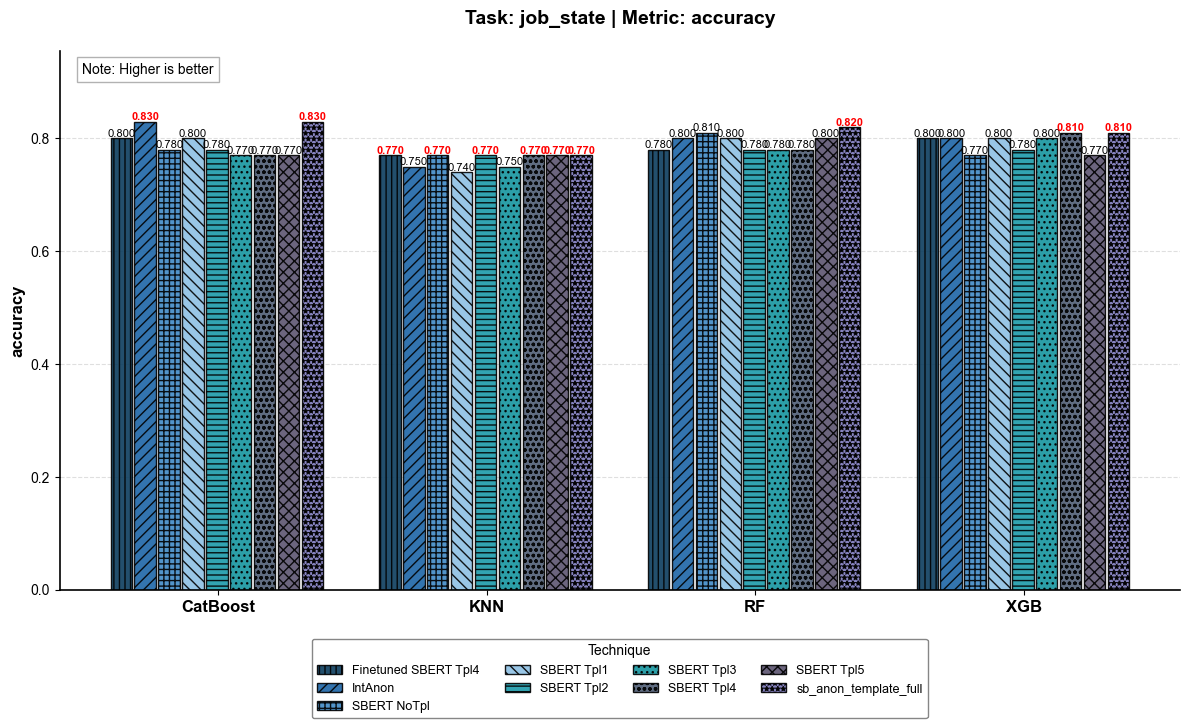

✅ Đã lưu PDF: PM100-charts_pdf/job_state_accuracy.pdf

📊 Plotting chart for Task: mem_pcon, Metric: MAE


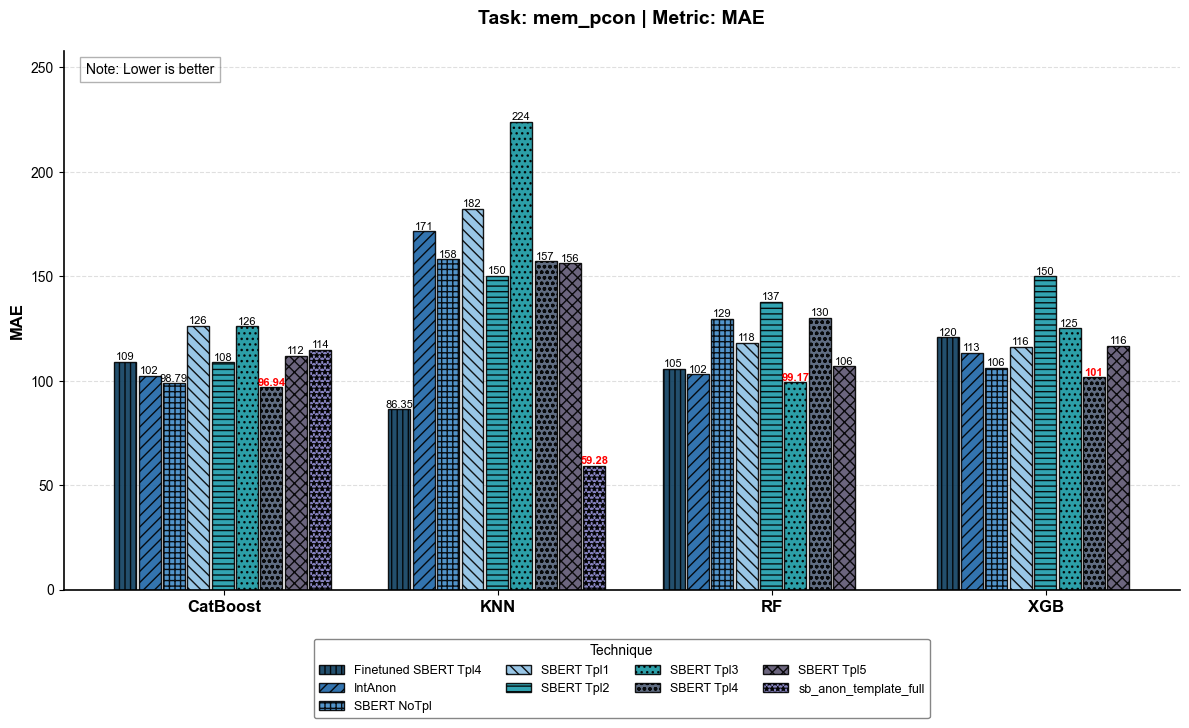

✅ Đã lưu PDF: PM100-charts_pdf/mem_pcon_MAE.pdf

📊 Plotting chart for Task: node_pcon, Metric: MAE


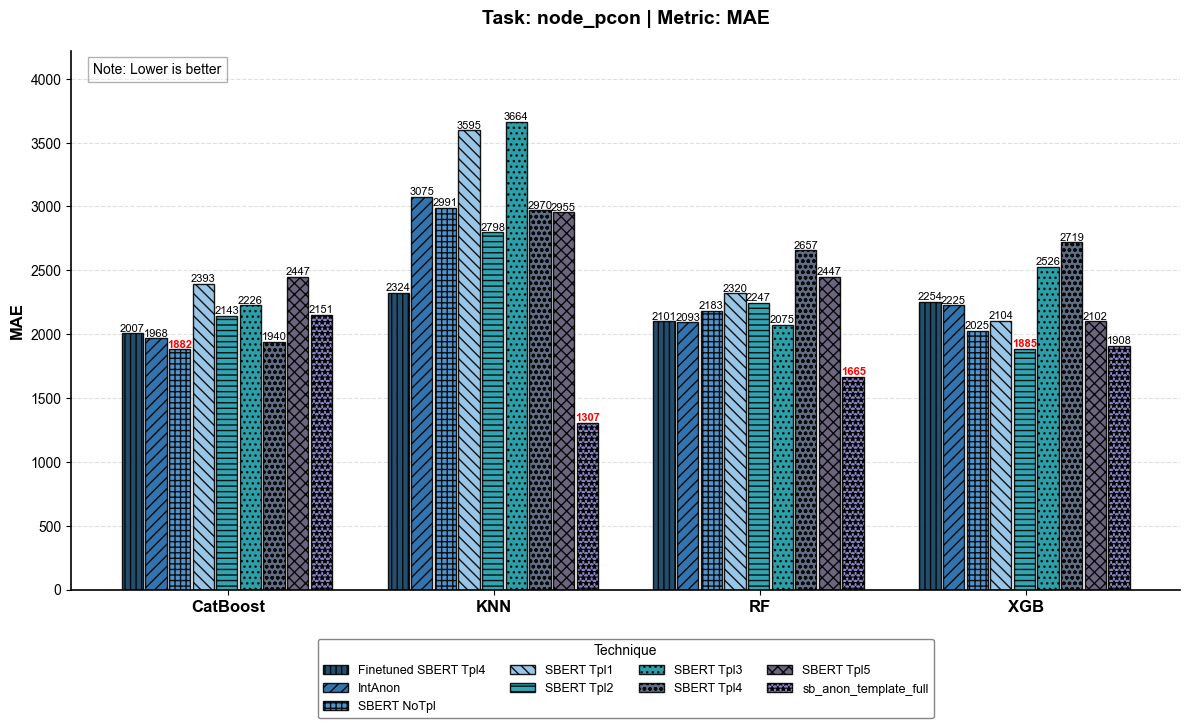

✅ Đã lưu PDF: PM100-charts_pdf/node_pcon_MAE.pdf

📊 Plotting chart for Task: run_time, Metric: MAE


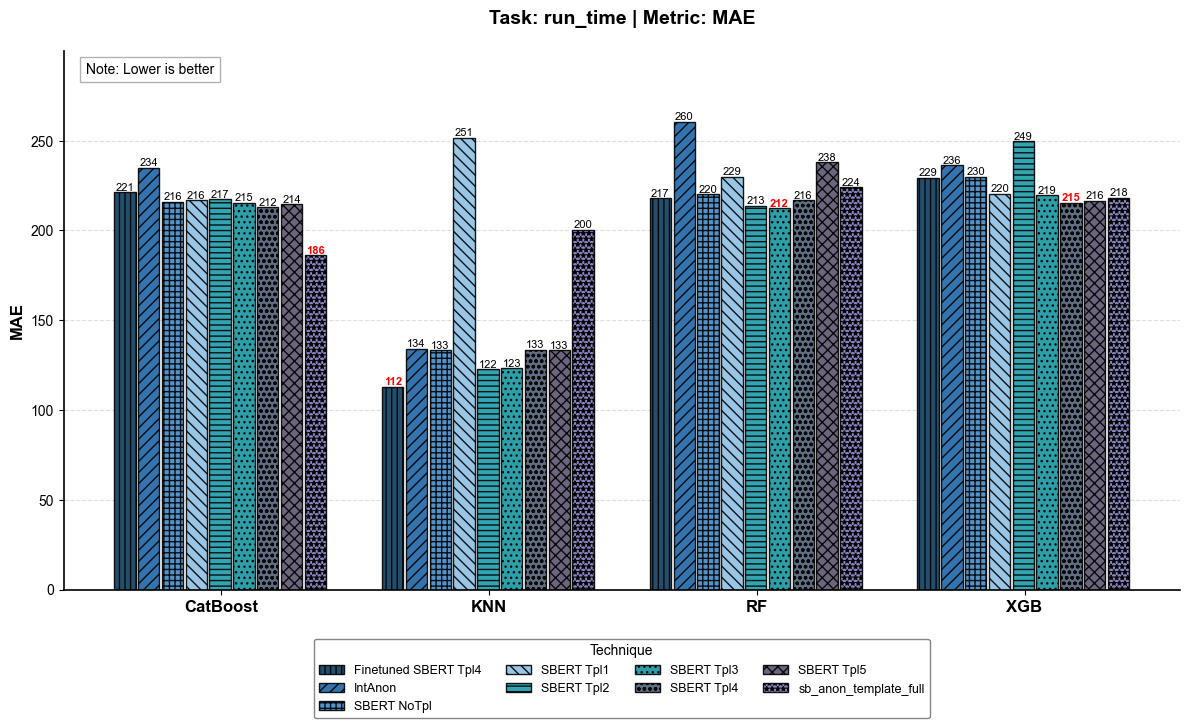

✅ Đã lưu PDF: PM100-charts_pdf/run_time_MAE.pdf


In [4]:
figures = plot_all_tasks(df)

```python
semantic_templates = [
        # Template 1: Cấu trúc bị động rút gọn (Compact Passive Construction)
        # Diễn đạt hành động “submit” ở dạng bị động nhằm đa dạng hóa ngữ pháp và trật tự thông tin.
        # Câu mô tả ngắn gọn, đưa "Job" lên đầu để nhấn mạnh đối tượng công việc, đồng thời vẫn giữ đủ ba thực thể: user – job – environment.
        lambda r: f"Job submitted by user {r['usr']} with name {r['jnam']} requiring environment {r['jobenv_req']}.",

        # Template 2: Tập trung vào Chủ thể/Hành động cơ bản (User–Job–Environment Relation)
        # Mô tả trực tiếp mối quan hệ giữa người dùng (user), công việc (job) và môi trường tính toán (environment).
        # Cấu trúc đơn giản, dễ hiểu, giúp mô hình học được ngữ cảnh cơ bản của hành động “submit”.
        lambda r: f"The user profile {r['usr']} submitted a computation {r['jnam']} to the environment {r['jobenv_req']}.",
        
        # Template 3: Tập trung vào Ngữ cảnh/Môi trường (Environment Focus)
        # Nhấn mạnh rằng môi trường được yêu cầu cho một tác vụ cụ thể của người dùng.
        lambda r: f"The high-priority computational environment {r['jobenv_req']} was specifically requested by user {r['usr']} for running the job named {r['jnam']}.",
        
        # Template 4: Tập trung vào Đối tượng/Công việc (Job Focus)
        # Nhấn mạnh tính chất của Job và vai trò của User/Environment đối với Job đó.
        lambda r: f"Job {r['jnam']}, which will be executed by {r['usr']}, requires exclusive access to the infrastructure {r['jobenv_req']}.",
        
        # Template 5: Mối quan hệ Hành động & Liên kết (Action & Association)
        # Dùng các động từ mạnh hơn để mô tả hành động lập lịch/chạy.
        lambda r: f"The scheduling system recorded that {r['usr']} is deploying job {r['jnam']} onto the {r['jobenv_req']} partition.",
        
        # Template 6: Cú pháp bị động (Passive Voice)
        # Thử nghiệm các cấu trúc câu khác để buộc mô hình học các phụ thuộc khác.
        lambda r: f"The hardware configuration {r['jobenv_req']} is being utilized by job {r['jnam']} which was initialized by {r['usr']}."
    ]
```

🧠 Task: avgpcon

| Model   | Template 2   | Template 4 | hpcb-template2 | hpcb-template4 | hpcb-kmeans-template4 | hpcb-multitask-template4 |
| ------- | ------------ | ---------- | -------------- | -------------- | -------------- | -------------- |
| **KNN** | Top 3        | Top 4      | Top 6          | Top 5          | Top 7          | Top 7          |
| **RF**  | Top 3        | Top 5      | Top 3          | Top 2          | Top 2          | Top 2          |
| **XG**  | 🥇 **Top 1** | Top 4      | Top 2          | Top 3          | Top 3          | Top 1          |
| **CatBoost**  |  |      |           |           |          | Top 2          |

⏱️ Task: duration

| Model   | Template 2   | Template 4 | hpcb-template2 | hpcb-template4 | hpcb-kmeans-template4 | hpcb-multitask-template4 |
| ------- | ------------ | ---------- | -------------- | -------------- | -------------- | -------------- |
| **KNN** | 🥇 **Top 1** | Top 9      | Top 2          | 🥇 **Top 1**   | Top 4          | Top 7          |
| **RF**  | Top 6        | Top 5      | 🥇 **Top 1**   | Top 2          | Top 1          | Top 1          |
| **XG**  | Top 3        | Top 4      | Top 3          | 🥇 **Top 1**   | Top 2          | Top 1          |
| **CatBoost**  |   |      |          |           |           | Top 1          |


⚡ Task: ec

| Model   | Template 2   | Template 4 | hpcb-template2 | hpcb-template4 | hpcb-kmeans-template4 | hpcb-multitask-template4 |
| ------- | ------------ | ---------- | -------------- | -------------- | -------------- | -------------- |
| **KNN** | Top 4        | 🥇 **Top 1** | Top 5          | Top 7          | Top 5          | Top 1          |
| **RF**  | Top 3        | 🥇 **Top 1** | Top 4          | Top 4          | Top 2          | Top 1          |
| **XG**  | Top 3        | 🥇 **Top 1** | 🥇 **Top 1**   | 🥇 **Top 1**   | Top 4          | Top 1          |
| **CatBoost**  |  |       |          |         |          | Top 1          |

📊 Task: pclass

| Model   | Template 2 | Template 4   | hpcb-template2 | hpcb-template4 | hpcb-kmeans-template4 | hpcb-multitask-template4 |
| ------- | ---------- | ------------ | -------------- | -------------- | -------------- | -------------- |
| **KNN** | Top 4      | 🥇 **Top 1** | Top 5          | Top 7          | Top 1          | Top 4          |
| **RF**  | Top 2      | Top 2        | Top 2          | Top 2          | Top 1          | Top 5          |
| **XG**  | Top 2      | Top 2        | Top 3           | Top 2        | Top 2          | Top 2          |
| **CatBoost**  |  |     |         |        |         | Top 4          |


In [5]:
import os
import json
import pandas as pd

root_dir = "models/finetuned_all-MiniLM-L6-v2_multitask"  # Thư mục gốc
results = []

# Duyệt tất cả các folder con
for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename == "training_log.json":
            file_path = os.path.join(dirpath, filename)
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                task = data.get("task", os.path.basename(dirpath))
                cos_before = data.get("cos_before", {})
                cos_after = data.get("cos_after", {})

                results.append({
                    "task": task,
                    "cosine_pos_before": cos_before.get("pos"),
                    "cosine_neg_before": cos_before.get("neg"),
                    "cosine_pos_after": cos_after.get("pos"),
                    "cosine_neg_after": cos_after.get("neg"),
                })
            except Exception as e:
                print(f"⚠️ Error reading {file_path}: {e}")

# Chuyển thành DataFrame
df = pd.DataFrame(results)
df["pos_diff"] = abs(df["cosine_pos_after"] - df["cosine_pos_before"])
df["neg_diff"] = abs(df["cosine_neg_after"] - df["cosine_neg_before"])

print(df)
df.to_excel("PM100-charts_pdf/finetuned_summary_pm100.xlsx", index=False)
print("\n✅ Saved summary to finetuned_summary_pm100.xlsx")

        task  cosine_pos_before  cosine_neg_before  cosine_pos_after  \
0   cpu_pcon           0.960517           0.955813          0.766256   
1  job_state           0.956306           0.955857          0.720994   
2   mem_pcon           0.963239           0.954784          0.784388   
3  node_pcon           0.960971           0.955045          0.778932   
4   run_time           0.959937           0.955737          0.740914   

   cosine_neg_after  pos_diff  neg_diff  
0          0.458895  0.194261  0.496918  
1          0.589878  0.235312  0.365979  
2          0.475062  0.178851  0.479722  
3          0.533490  0.182038  0.421555  
4          0.556641  0.219023  0.399096  

✅ Saved summary to finetuned_summary_pm100.xlsx
